In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

/home/mazor/nn/nn/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random

def set_seed(seed):
    """
    Set the seed for reproducibility.
    """
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Set the seed for numpy for reproducibility
    random.seed(seed)  # Set Python random seed
    # Ensures that CUDA operations are deterministic
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False

# Example: Setting the seed to 42
set_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batch_size = 32
# Transform to convert images to PyTorch tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# TODO Changing shuffle to True results in the input data shuffling every epoch; 
# this is causing some undefined behavior with our expected and predicted outputs
# Possible fixes: store inputs in a dictionary with unique IDs,
# Store trainloader as a class member

# Download and load the training data for MNIST
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


Using device: cuda


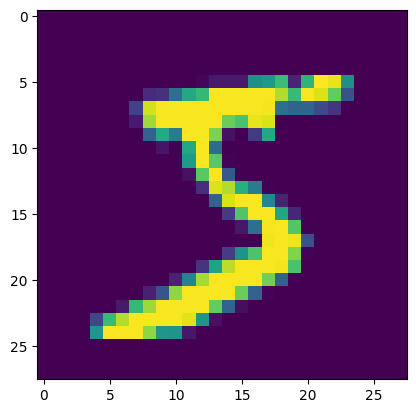

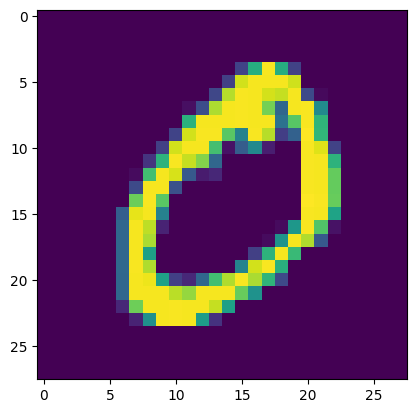

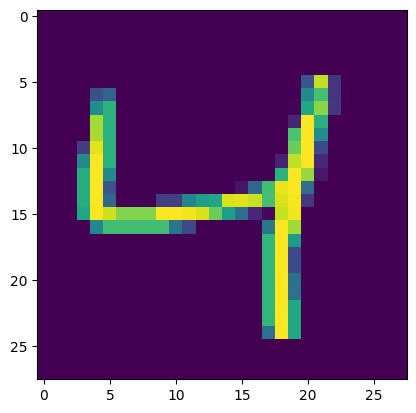

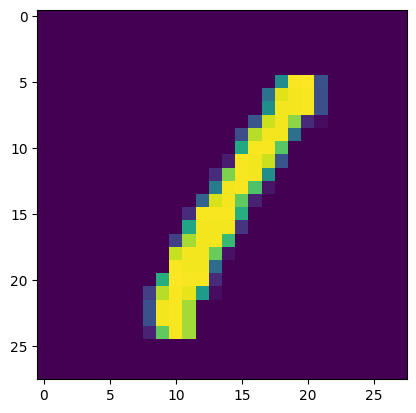

In [4]:
all_images = []
all_indices = []
for i, (images, labels) in enumerate(trainloader):
    all_images.extend(images)
    all_indices.extend(range(i * len(images), (i + 1) * len(images)))

# Convert the list to a NumPy array
all_images = torch.stack(all_images)
all_indices = torch.tensor(all_indices)



# Function to display an image given its index
def imshow_by_index(index):
    img = all_images[index] / 2 + 0.5  # Unnormalize
    plt.imshow(img.permute(1, 2, 0))  # Convert from Tensor image
    plt.show()

# Example: Display the first four images
for i in range(4):
    imshow_by_index(i)

In [5]:
class TrainableNode(nn.Module):
    def __init__(self, input_features, output_features):
        super(TrainableNode, self).__init__()
        self.linear = nn.Linear(input_features, output_features)
        self.is_explainable = True
    def forward(self, x):
        return self.linear(x)


class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        # Assuming MNIST images are 1x28x28 (channels x width x height)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2) # Output: 32x28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2) # Output: 64x14x14
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 64x7x7 after pooling
        
        # Flatten: 64*7*7 = 3136 features
        self.fc1 = nn.Linear(3136, 128) # Fully connected layer
        
        # Trainable node for explainability, assuming it requires a flattened input
        self.explainable_node = TrainableNode(128, 1)
        
        self.fc2 = nn.Linear(128, 64) # Additional fully connected layer
        self.fc3 = nn.Linear(64, 10) # Final layer for classifying into 10 classes
        
    def forward(self, x, return_explainable=False):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        x1 = F.relu(self.fc1(x))
        
        if return_explainable:
            explainable_output = self.explainable_node(x1).squeeze()
        
        x = F.relu(self.fc2(x1))
        x = self.fc3(x)
        
        if return_explainable:
            return x, explainable_output
        return x


    def forward_with_explainable(self, x):
        # Directly pass the input to the explainable_node without additional transformations
        explainable_output = self.explainable_node(x)
        return explainable_output
        

class ExplainableNetwork:
    def __init__(self, model):
        self.model = model
        self.activations_per_input = {}
        self.gradients_per_input = {} 
        self.current_epoch = 0
        self.num_epochs = 0
        self.batch_counter = 0
        self.layer_names = []
        self.explainable_module_names = set()
        explainable_module_names = set()
        for name, module in model.named_modules():
            if getattr(module, 'is_explainable', False):
                explainable_module_names.add(name)
        for name, module in model.named_modules():
            if name and not any(part in explainable_module_names for part in name.split('.')):
                self.layer_names.append(name)
            elif name:
                self.explainable_module_names.add(name)

        self.expected_outputs = []
        self.predicted_outputs = []

        self.hook_handles = [] 

        self.enable_hooks()
        
    # def getNonExpLayers(model):
    #     layers = []
    #     for name, module in model.named_modules():
    #         if name != '' and not isinstance(module, TrainableNode):
    #             layers.append(name)
    #     return layers

    # Register hooks for each layer
    def enable_hooks(self):
        for name, module in self.model.named_modules():
            if name in self.explainable_module_names:  # Skip the explainable_node by its name
                continue
            # Check if the module is a type that we want to hook (Conv2d, Linear, or pooling layers)
            if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.MaxPool2d)):
                forward_handle = module.register_forward_hook(self.create_forward_hook(name))
                backward_handle = module.register_full_backward_hook(self.create_backward_hook(name))
                self.hook_handles.append(forward_handle)
                self.hook_handles.append(backward_handle)
    def disable_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = []  # Clear the list after removing all hooks

    def create_forward_hook(self, layer_name):
        def forward_hook(module, input, output):
            if self.current_epoch == self.num_epochs - 1:
                self.store_activations(layer_name, output)
        return forward_hook

    def create_backward_hook(self, layer_name):
        def backward_hook(module, grad_input, grad_output):
            if self.current_epoch == self.num_epochs - 1:
                self.store_gradients(layer_name, grad_output[0])
        return backward_hook
    def store_activations(self, layer_name, output):
        self._store_per_input(self.activations_per_input, layer_name, output)

    def store_gradients(self, layer_name, gradient):
        # Store gradients for the last epoch
        if self.current_epoch == self.num_epochs - 1:
            batch_size = gradient.size(0)
            for i in range(batch_size):
                input_index = self.batch_counter * batch_size + i
                if input_index not in self.gradients_per_input:
                    self.gradients_per_input[input_index] = {}
                self.gradients_per_input[input_index][layer_name] = gradient[i].detach().cpu().numpy()
    
            # Increment the backward batch counter only after processing the first layer (which is the last layer in the forward pass)


    def _store_per_input(self, storage_dict, layer_name, tensor):
        batch_size = tensor.size(0)
        for i in range(batch_size):
            input_index = self.batch_counter * batch_size + i
            if input_index not in storage_dict:
                storage_dict[input_index] = {}
            storage_dict[input_index][layer_name] = tensor[i].detach().cpu().numpy()

        if layer_name == self.layer_names[-1]:
            self.batch_counter += 1

    def start_epoch(self, epoch, num_epochs):
        self.current_epoch = epoch
        self.num_epochs = num_epochs
        if epoch == num_epochs - 1:
            self.batch_counter = 0  # Reset the batch counter on the last epoch

    def get_activations(self, input_index):
        return self.activations_per_input.get(input_index, None)

    def get_gradients(self, input_index):
        return self.gradients_per_input.get(input_index, None)

    def print_structure(self):
        print("Explainable Network Structure and Data Summary:")

        # Check if there is any data collected
        if not self.activations_per_input:
            print("No activations data collected.")
            return

        if not self.gradients_per_input:
            print("No gradients data collected.")
            return

        # Print information about activations
        print("\nActivations:")
        first_input_activations = next(iter(self.activations_per_input.values()))
        for layer_name, activations in first_input_activations.items():
            num_nodes = len(activations)
            num_data_points = len(self.activations_per_input)
            print(f"Layer {layer_name}: {num_nodes} nodes, {num_data_points} data points each")

        # Print information about gradients
        print("\nGradients:")
        first_input_gradients = next(iter(self.gradients_per_input.values()))
        for layer_name, gradients in first_input_gradients.items():
            num_nodes = len(gradients)
            num_data_points = len(self.gradients_per_input)
            print(f"Layer {layer_name}: {num_nodes} nodes, {num_data_points} data points each")
            
    # FIXME: Add functionality for first layer
    def get_node_input(self, layer_name, node_index, image_index):
        if layer_name != self.layer_names[0] and layer_name in self.layer_names:
            # For subsequent layers, we use activations from the previous layer
            prev_layer_name = self.get_previous_layer_name(layer_name)
            prev_activations = self.activations_per_input[image_index][prev_layer_name]
        
            # Ensure the prev_activations is a 1D array for proper multiplication
            if prev_activations.ndim > 1:
                prev_activations = prev_activations.flatten()

        return prev_activations

    def find_extreme_activations(self, std_dev_threshold=3, label_digit=0, pred_digit=0):
            """
            Find inputs where node activations are more than +3 or less than -3 standard deviations from the mean.

            Args:
            std_dev_threshold (float): The number of standard deviations to use as a threshold for extreme activations.

            Returns:
            dict: A dictionary containing two keys ('high' and 'low') each mapping to a dict of nodes and their corresponding extreme input indices.
            """

            # Calculate mean and standard deviation for each node
            node_stats = {}  # Dictionary to store mean and std for each node
            for _, layers_activations in self.activations_per_input.items():
                for layer_name, activations in layers_activations.items():
                    if layer_name not in node_stats:
                        node_stats[layer_name] = []
                    node_stats[layer_name].append(activations)

            for layer_name, activations_list in node_stats.items():
                node_stats[layer_name] = {
                    'mean': np.mean(activations_list, axis=0),
                    'std': np.std(activations_list, axis=0)
                }

            activations_structure = {}

            # Assuming 'model' is your neural network model
            for name, module in self.model.named_modules():
                # Skip the model itself as it's also returned by named_modules
                if name != "" and name in self.layer_names:
                    activations_structure[name] = {'high': {}, 'low': {}}

            # Identify inputs with extreme activations
            for input_index, layers_activations in self.activations_per_input.items():
                for layer_name, activations in layers_activations.items():
                    if self.expected_outputs[input_index] == label_digit and self.predicted_outputs[input_index] == pred_digit:
                        mean = node_stats[layer_name]['mean']
                        std = node_stats[layer_name]['std']
                        high_threshold = mean + std_dev_threshold * std
                        low_threshold = mean - std_dev_threshold * std

                        high_indices = np.where(activations > high_threshold)[0]
                        low_indices = np.where(activations < low_threshold)[0]

                        for idx in high_indices:
                            activations_structure[layer_name]['high'][idx] = activations_structure[layer_name]['high'].get(idx, 0) + 1
                        for idx in low_indices:
                            activations_structure[layer_name]['low'][idx] = activations_structure[layer_name]['low'].get(idx, 0) + 1
            return activations_structure
            
    def get_previous_layer_name(self, current_layer_name):
        try:
            index = self.layer_names.index(current_layer_name)
        except ValueError:
            print("Layer name not found in the model.")
            return None
        
        if index == 0:
            return None
        else:
            return self.layer_names[index - 1]






In [6]:
model = MNISTNet().to(device)
explainable_net = ExplainableNetwork(model)
print(f'layers: {explainable_net.layer_names}')
print(f'explainable layers: {explainable_net.explainable_module_names}')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2  # Adjust as needed

for epoch in range(num_epochs):
    explainable_net.start_epoch(epoch, num_epochs)
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        if epoch == num_epochs - 1:
            explainable_net.expected_outputs.extend(targets.cpu().numpy())
            
            # Convert outputs to predicted class labels
            _, predicted = torch.max(outputs, 1)
            explainable_net.predicted_outputs.extend(predicted.cpu().numpy())
        


layers: ['conv1', 'conv2', 'pool', 'fc1', 'fc2', 'fc3']
explainable layers: {'explainable_node', 'explainable_node.linear'}


In [7]:
explainable_net.print_structure()

Explainable Network Structure and Data Summary:

Activations:
Layer conv1: 32 nodes, 60000 data points each
Layer pool: 64 nodes, 60000 data points each
Layer conv2: 64 nodes, 60000 data points each
Layer fc1: 128 nodes, 60000 data points each
Layer fc2: 64 nodes, 60000 data points each
Layer fc3: 10 nodes, 60000 data points each

Gradients:
Layer fc3: 10 nodes, 60000 data points each
Layer fc2: 64 nodes, 60000 data points each
Layer fc1: 128 nodes, 60000 data points each
Layer pool: 32 nodes, 60000 data points each
Layer conv2: 64 nodes, 60000 data points each
Layer conv1: 32 nodes, 60000 data points each


In [8]:
sample_size = 10

print(len(explainable_net.expected_outputs))
print(len(explainable_net.predicted_outputs))

print("Sample of Expected Outputs:", explainable_net.expected_outputs[:sample_size])
print("Sample of Predicted Outputs:", explainable_net.predicted_outputs[:sample_size])

60000
60000
Sample of Expected Outputs: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]
Sample of Predicted Outputs: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [9]:
# Normalizes the predictions (i, j) to the total number of predictions(i, _) for all predictions
# Returns a 2D array such that probabilities[i][j] holds the probability of the model
# predicting last_layer[i] as last_layer[j]
def calculate_probabilities(classifier_outcomes, label_counts):
    probabilities = np.zeros_like(classifier_outcomes, dtype=np.float64)
    for i in range(len(label_counts)):
        if label_counts[i] > 0:  # Prevent division by zero
            probabilities[i] = classifier_outcomes[i] / label_counts[i]
    return probabilities


In [10]:
model.eval()
correct = 0
total = 0

final_layer_size = list(explainable_net.model.named_modules())[-1][1].out_features
# classifier_outcomes[i][j] will store the probability of the model incorrectly classifying digit i as digit j.
# The diagonals store the probability of a correct predicition
classifier_outcomes = np.zeros((final_layer_size, final_layer_size), dtype=np.float64)
label_counts = np.zeros(final_layer_size, dtype=np.int64)

explainable_net.disable_hooks() 
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Initialize classifier_outcomes as the frequency of each prediction (label, pred)
        for label, pred in zip(labels, predicted):
            classifier_outcomes[label.item()][pred.item()] += 1
            # Store the number of total attempts at predicting 'label'
            label_counts[label.item()] += 1

classifier_outcomes = calculate_probabilities(classifier_outcomes, label_counts)
accuracy = 100 * correct / total
print(f'Accuracy of the model on the 10000 test images: {accuracy}%')


Accuracy of the model on the 10000 test images: 98.87%


In [11]:
# Turns classifier_outcomes into a pandas.DataFrame for easier visualization
def display_classifier_outcomes_table(classifier_outcomes, mode='percent'):
    size = classifier_outcomes.shape[0]
    df = pd.DataFrame(classifier_outcomes, 
                      columns=[f'Predicted {j}' for j in range(size)], 
                      index=[f'Actual {i}' for i in range(size)])
    
    if mode == 'percent':
        df = df * 100
        fmt = "{:.4f}%"
    elif mode == 'probability':
        fmt = "{:.4f}"
    
    pd.set_option('display.float_format', fmt.format)
    
    # Display table
    print(df)

display_classifier_outcomes_table(classifier_outcomes, 'probability')

          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  \
Actual 0       0.9959       0.0010       0.0000       0.0000       0.0000   
Actual 1       0.0000       0.9974       0.0009       0.0000       0.0000   
Actual 2       0.0010       0.0019       0.9922       0.0000       0.0000   
Actual 3       0.0000       0.0000       0.0040       0.9921       0.0000   
Actual 4       0.0000       0.0000       0.0010       0.0000       0.9969   
Actual 5       0.0011       0.0000       0.0011       0.0056       0.0000   
Actual 6       0.0042       0.0042       0.0000       0.0000       0.0010   
Actual 7       0.0000       0.0029       0.0097       0.0000       0.0000   
Actual 8       0.0031       0.0000       0.0031       0.0031       0.0010   
Actual 9       0.0010       0.0020       0.0000       0.0010       0.0059   

          Predicted 5  Predicted 6  Predicted 7  Predicted 8  Predicted 9  
Actual 0       0.0000       0.0000       0.0000       0.0020       0.0010  


In [12]:
label_digit = 0
pred_digit = 0
#extreme_activations_result = explainable_net.find_extreme_activations(label_digit=label_digit, pred_digit=pred_digit)

In [13]:
def print_activation_structure(struct, layer_names):
    extremity_types = ['high', 'low']

    for layer_name in layer_names:
        print(f"  Layer: {layer_name}")
        for ext_type in extremity_types:
            # Access the dictionary for the current layer and extremity type
            current_dict = struct[layer_name][ext_type]
            # Check if there are any nodes
            if current_dict:
                # Prepare the formatted string of (key, value) pairs
                formatted_pairs = ', '.join([f"({key}, {value})" for key, value in current_dict.items()])
                print(f"    {'High' if ext_type == 'high' else 'Low'} Extreme Activations: Nodes [{formatted_pairs}]")
            else:
                print(f"    {ext_type} Extreme Activations: None")
        print()  # New line for better readability between layers


# # Example usage
#print_activation_structure(extreme_activations_result, explainable_net.layer_names)

In [20]:
layer_name = 'pool'
node_index = 1
std_dev = 1.5

In [21]:
import pandas as pd

def plot_extreme_outliers(explainable_network, layer_name, node_index, std_dev_threshold=3, discriminate_classes=[-1,-1], Correct_pred_only=False):
    activations = []
    gradients = []
    colors = []
    labels = []
    classA = discriminate_classes[0]
    classB = discriminate_classes[1]
    
    # Define a color map for digits 0-9
    color_map = matplotlib.colormaps['tab10']

    # Retrieve activations, gradients, and check for correct predictions
    for input_index, (expected, predicted) in enumerate(zip(explainable_network.expected_outputs, explainable_network.predicted_outputs)):
        if expected == predicted or not Correct_pred_only:
            activation = explainable_network.get_activations(input_index)
            gradient = explainable_network.get_gradients(input_index)

            if activation is not None and gradient is not None:
                activations.append(activation[layer_name][node_index])
                gradients.append(-gradient[layer_name][node_index])  # Negative of the gradient
                colors.append(color_map(expected))  # Color code based on the correct digit
                labels.append(expected)
            

    # Convert lists to numpy arrays for numerical operations
    activations = np.array(activations)
    gradients = np.array(gradients)
    labels = np.array(labels)
    colors = np.array(colors)

    # Calculate mean and standard deviation for activations and gradients
    activation_mean = np.mean(activations)
    activation_std = np.std(activations)
    gradient_mean = np.mean(gradients)
    gradient_std = np.std(gradients)

    # Apply filtering for points that are more than std_dev_threshold away in both dimensions
    extreme_outliers = (np.abs(activations - activation_mean) > std_dev_threshold * activation_std) & \
                       (np.abs(gradients - gradient_mean) > std_dev_threshold * gradient_std)

    # Filter activations, gradients, and colors based on the extreme outlier condition
    activations_extreme = activations[extreme_outliers]
    gradients_extreme = gradients[extreme_outliers]
    labels_extreme = labels[extreme_outliers]
    colors_extreme = colors[extreme_outliers]

    # Create Dataframe for easy use
    df = pd.DataFrame({'Activations': activations_extreme, 'Gradients': gradients_extreme, 'Labels': labels_extreme})
    
    if classA > -1 and classB > -1:
        #condition = np.logical_or(colors_extreme[labels == classA], colors_extreme[labels == classB])
        colors_extreme = colors_extreme[df['Labels'].isin([classA, classB])]
        df = df[df['Labels'].isin([classA, classB])]

    # Generate scatter plot with extreme outliers
    fig, ax = plt.subplots(figsize=(15, 10))
    scatter = ax.scatter(df.loc[:, ['Activations']], df.loc[:, ['Gradients']], c= colors_extreme, cmap=color_map, s=15)
    ax.set_xlabel('Activation')
    ax.set_ylabel('Negative of Gradient')
    ax.set_title(f'Extreme Outliers Scatter Plot for {layer_name} - Node {node_index}')

    # Create a colorbar
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(0, 9)), ax=ax, ticks=np.arange(0, 10))
    cbar.set_label('Digit')

    ax.grid(True)
    plt.show()

In [22]:
plot_extreme_outliers(explainable_net, layer_name, node_index, std_dev_threshold=0, Correct_pred_only=False)  # Adjust std_dev_threshold as needed

ValueError: operands could not be broadcast together with shapes (59968,7,7) (59968,14,14) 

In [ ]:
plot_extreme_outliers(explainable_net, layer_name, node_index, std_dev_threshold=std_dev, Correct_pred_only=False)  # Adjust std_dev_threshold as needed

In [ ]:
plot_extreme_outliers(explainable_net, layer_name, node_index, std_dev_threshold=std_dev, Correct_pred_only=False, discriminate_classes=[1,3])

In [ ]:
import pandas as pd

def plot_extreme_outliers_quad(explainable_network, layer_name, node_index, quadrant, std_dev_threshold=3, selected_class=-1):
    activations = []
    gradients = []
    labels = []
    imgIndx = []
    colors = []
    
     # Define a color map for digits 0-9
    color_map = matplotlib.colormaps['tab10']

    # Retrieve activations, gradients, and check for correct predictions
    for input_index, (expected, predicted) in enumerate(zip(explainable_network.expected_outputs, explainable_network.predicted_outputs)):
        #if expected == predicted: do we want to filter this?
        activation = explainable_network.get_activations(input_index)
        gradient = explainable_network.get_gradients(input_index)

        if activation is not None and gradient is not None:
            activations.append(activation[layer_name][node_index])
            gradients.append(-gradient[layer_name][node_index])  # Negative of the gradient
            labels.append(expected)
            imgIndx.append(input_index)
            colors.append(color_map(expected))  # Color code based on the correct digit
            

    # Convert lists to numpy arrays for numerical operations
    activations = np.array(activations)
    gradients = np.array(gradients)
    labels = np.array(labels)
    imgIndx = np.array(imgIndx)
    colors = np.array(colors)


    # Calculate mean and standard deviation for activations and gradients
    activation_mean = np.mean(activations)
    activation_std = np.std(activations)
    gradient_mean = np.mean(gradients)
    gradient_std = np.std(gradients)

    # Apply filtering for points that are more than std_dev_threshold away in both dimensions
    extreme_outliers = (np.abs(activations - activation_mean) > std_dev_threshold * activation_std) & \
                       (np.abs(gradients - gradient_mean) > std_dev_threshold * gradient_std)

    # Filter activations, gradients, and colors based on the extreme outlier condition
    activations_extreme = activations[extreme_outliers]
    gradients_extreme = gradients[extreme_outliers]
    labels_extreme = labels[extreme_outliers]
    colors_extreme = colors[extreme_outliers]
    imgIndx = imgIndx[extreme_outliers]

    # Create Dataframe for easy use
    df = pd.DataFrame({'Index':imgIndx,'Activations': activations_extreme, 'Gradients': gradients_extreme, 'Labels': labels_extreme})
    
    if selected_class > -1:
        colors_extreme = colors_extreme[df['Labels'] == selected_class]
        df = df[df['Labels'] == selected_class]
        
    if quadrant == 1:
        colors_extreme = colors_extreme[df['Gradients'] > 0]
        df = df[df['Gradients'] > 0]
        colors_extreme = colors_extreme[df['Activations'] > 0]
        df = df[df['Activations'] > 0]
    elif quadrant == 2:
        colors_extreme = colors_extreme[df['Gradients'] > 0]
        df = df[df['Gradients'] > 0]
        colors_extreme = colors_extreme[df['Activations'] < 0]
        df = df[df['Activations'] < 0]
        
    elif quadrant == 3:
        colors_extreme = colors_extreme[df['Gradients'] < 0]
        df = df[df['Gradients'] < 0]
        colors_extreme = colors_extreme[df['Activations'] < 0]
        df = df[df['Activations'] < 0]
        
    elif quadrant == 4:
        colors_extreme = colors_extreme[df['Gradients'] < 0]
        df = df[df['Gradients'] < 0]
        colors_extreme = colors_extreme[df['Activations'] > 0]
        df = df[df['Activations'] > 0]
        
    # Generate scatter plot with extreme outliers
    fig, ax = plt.subplots(figsize=(15, 10))
    scatter = ax.scatter(df.loc[:, ['Activations']], df.loc[:, ['Gradients']], c=colors_extreme, cmap=color_map, s=15)
    ax.set_xlabel('Activation')
    ax.set_ylabel('Negative of Gradient')
    ax.set_title(f'Extreme Outliers Scatter Plot for {layer_name} - Node {node_index}')

    # Create a colorbar
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(0, 9)), ax=ax, ticks=np.arange(0, 10))
    cbar.set_label('Digit')

    ax.grid(True)
    plt.show()


# Example usage:
plot_extreme_outliers_quad(explainable_net, layer_name, node_index, std_dev_threshold=1.5, quadrant= 1, selected_class=1)  # Adjust std_dev_threshold as needed



In [ ]:
import pandas as pd

def extreme_outliers_quad(explainable_network, layer_name, node_index, quadrant, std_dev_threshold=3, selected_class=-1):
    activations = []
    gradients = []
    labels = []
    imgIndx = []

    # Retrieve activations, gradients, and check for correct predictions
    for input_index, (expected, predicted) in enumerate(zip(explainable_network.expected_outputs, explainable_network.predicted_outputs)):
        #if expected == predicted: do we want to filter this?
        activation = explainable_network.get_activations(input_index)
        gradient = explainable_network.get_gradients(input_index)

        if activation is not None and gradient is not None:
            activations.append(activation[layer_name][node_index])
            gradients.append(-gradient[layer_name][node_index])  # Negative of the gradient
            labels.append(expected)
            imgIndx.append(input_index)
            

    # Convert lists to numpy arrays for numerical operations
    activations = np.array(activations)
    gradients = np.array(gradients)
    labels = np.array(labels)
    imgIndx = np.array(imgIndx)


    # Calculate mean and standard deviation for activations and gradients
    activation_mean = np.mean(activations)
    activation_std = np.std(activations)
    gradient_mean = np.mean(gradients)
    gradient_std = np.std(gradients)

    # Apply filtering for points that are more than std_dev_threshold away in both dimensions
    extreme_outliers = (np.abs(activations - activation_mean) > std_dev_threshold * activation_std) & \
                       (np.abs(gradients - gradient_mean) > std_dev_threshold * gradient_std)

    # Filter activations, gradients, and colors based on the extreme outlier condition
    activations_extreme = activations[extreme_outliers]
    gradients_extreme = gradients[extreme_outliers]
    labels_extreme = labels[extreme_outliers]
    imgIndx = imgIndx[extreme_outliers]

    # Create Dataframe for easy use
    df = pd.DataFrame({'Index':imgIndx,'Activations': activations_extreme, 'Gradients': gradients_extreme, 'Labels': labels_extreme})
    
    if selected_class > -1:
        df = df[df['Labels'] == selected_class]
        
    if quadrant == 1:
        df = df[df['Activations'] > 0]
        df = df[df['Gradients'] > 0]
        
    elif quadrant == 2:
        df = df[df['Activations'] < 0]
        df = df[df['Gradients'] > 0]
        
    elif quadrant == 3:
        df = df[df['Activations'] < 0]
        df = df[df['Gradients'] < 0]
        
    elif quadrant == 4:
        df = df[df['Activations'] > 0]
        df = df[df['Gradients'] < 0]
    
    return df['Index'].values


# Example usage:
displayPos = extreme_outliers_quad(explainable_net, 'fc2', node_index, std_dev_threshold=1.5, quadrant= 1)  # Adjust std_dev_threshold as needed
displayNeg = extreme_outliers_quad(explainable_net, 'fc2', node_index, std_dev_threshold=1.5, quadrant= 3)  # Adjust std_dev_threshold as needed

truePos =  extreme_outliers_quad(explainable_net, 'fc2', node_index, std_dev_threshold=1.5, quadrant= 1, selected_class = 1)  
trueNeg =  extreme_outliers_quad(explainable_net, 'fc2', node_index, std_dev_threshold=1.5, quadrant= 3, selected_class = 3)  


In [ ]:
def display_image_grid(images, rows, cols):
    grid = torchvision.utils.make_grid(images, nrow=cols)
    grid = grid / 2 + 0.5  # Unnormalize
    plt.figure(figsize=(15, 15))  # Adjust the size as needed
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

# Number of images per grid
images_per_grid = 128  # for example, a 4x4 grid

# Calculate rows and columns for the grid
cols = 10  # Number of columns
rows = images_per_grid // cols

# Display the images in grids
for i in range(0, len(displayPos), images_per_grid):
    selected_indices = displayPos[i:i+images_per_grid]
    selected_images = torch.stack([all_images[index] for index in selected_indices])
    display_image_grid(selected_images, rows, cols)

for i in range(0, len(displayNeg), images_per_grid):
    selected_indices = displayNeg[i:i+images_per_grid]
    selected_images = torch.stack([all_images[index] for index in selected_indices])
    display_image_grid(selected_images, rows, cols)

In [ ]:
images_subset = torch.stack([all_images[i] for i in displayPos])
average_image = images_subset.float().mean(dim=0).squeeze()
plt.imshow(average_image, cmap='gray')
plt.title("Average Positive Image")
plt.colorbar()
plt.show()

normalized_image = (average_image - average_image.min()) / (average_image.max() - average_image.min())

# Apply a power law transformation to increase contrast, emphasizing the bright pixels
# Squaring the normalized pixel values will make high values brighter and low values dimmer
emphasized_positive_image = normalized_image ** 4

# Plot the emphasized average image
plt.imshow(emphasized_positive_image, cmap='gray')
plt.title("Emphasized Positive Average Image")
plt.colorbar()
plt.show()

In [ ]:
images_subset = torch.stack([all_images[i] for i in displayNeg])
average_image = images_subset.float().mean(dim=0).squeeze()
plt.imshow(average_image, cmap='gray')
plt.title("Average Negative Image")
plt.colorbar()
plt.show()

normalized_image = (average_image - average_image.min()) / (average_image.max() - average_image.min())

# Apply a power law transformation to increase contrast, emphasizing the bright pixels
# Squaring the normalized pixel values will make high values brighter and low values dimmer
emphasized_negative_image = normalized_image ** 4

# Plot the emphasized average image
plt.imshow(emphasized_negative_image, cmap='gray')
plt.title("Emphasized Average Negative Image")
plt.colorbar()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# TODO do some math to average pos and neg not just > or <

# Create an empty RGB image
heatmap = np.zeros((*emphasized_positive_image.shape, 3))

# Define a threshold for neutrality
threshold = 0.05  # Adjust based on your data's scale

# Fill the heatmap
for i in range(heatmap.shape[0]):
    for j in range(heatmap.shape[1]):
        pos = emphasized_positive_image[i, j]
        neg = emphasized_negative_image[i, j]
        if np.abs(pos - neg) < threshold:  # Neutral
            heatmap[i, j] = [0, 0, 0]  # White for neutral, change to [0, 0, 0] for black
        elif pos > neg:  # Positive
            heatmap[i, j] = [pos, 0, 0]  # Red intensity based on positive value
        else:  # Negative
            heatmap[i, j] = [0, 0, neg]  # Blue intensity based on negative value

# Display the heatmap
plt.imshow(heatmap)
plt.title("Merged Heatmap of Positive and Negative")
plt.show()


In [ ]:
trueNegData = []
truePosData = []

# Function to fetch data for each image index
def fetch_data_for_images(image_indices):
    data_array = []
    for index in image_indices:
        data = explainable_net.get_node_input(layer_name, node_index, index)
        data_array.append(data)
    return data_array

# Fetching data for trueNeg and truePos
trueNegData = fetch_data_for_images(trueNeg)
truePosData = fetch_data_for_images(truePos)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Assuming trueNegData and truePosData are lists of numpy arrays
trueNegData_np = np.array(trueNegData)
truePosData_np = np.array(truePosData)

# Convert numpy arrays into PyTorch tensors
trueNegData_tensor = torch.tensor(trueNegData_np, dtype=torch.float32)
truePosData_tensor = torch.tensor(truePosData_np, dtype=torch.float32)

# Create labels for the datasets
labels1 = torch.zeros(len(trueNegData), dtype=torch.float32)  # Labels for trueNegData
labels2 = torch.ones(len(truePosData), dtype=torch.float32)   # Labels for truePosData

# Combine datasets and labels
combined_dataset = torch.cat([trueNegData_tensor, truePosData_tensor], dim=0)
combined_labels = torch.cat([labels1, labels2], dim=0)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(combined_dataset, combined_labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model, optimizer, and loss function here
# Assuming `model` and `device` are defined elsewhere

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # Adjust as needed

for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model.forward_with_explainable(inputs).squeeze()

        # Ensure labels match the output shape
        labels = labels.view_as(outputs)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


In [ ]:
inputs = all_images[12].to(device)

model.eval()

# Forward pass to get both outputs
with torch.no_grad():
    regular_output, explainable_output = model(inputs, return_explainable=True)

print("Regular Output:", regular_output)
print("Explainable Output:", explainable_output)